In [1]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 2.9 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827636 sha256=b1a105d1d1f35859360eb31c6110b70dee867b1fb4aae21661c825e546e0f9c0
  Stored in directory: /Users/anurag/Library/Caches/pip/wheels/af/2b/30/5e78b8b9599f2a2286a582b8da80594f654bf0e18d825a4405
  Created wheel for mdptoolbox-hiive: filename=mdptoolbox_hiive-4.0.3.1-py3-none-any.whl size=35122 sha256=6827abf29433aceeefdb86e354222ed3673a4e2127d11f364f2f35b8b3438231
  Stored in directory: /Users/anurag/Library/Caches/pip/wheels/41/46/f6/64afe48808e5822c79f31a336dd31d05ebe304d45e555fac19
Successfully built gym mdptoolbox-hiive

[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [167]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re
import gym
from gym import wrappers
from gym.envs.toy_text.frozen_lake import generate_random_map, FrozenLakeEnv
from hiive.mdptoolbox.mdp import ValueIteration, PolicyIteration, QLearning
#from hiive.mdptoolbox.openai import OpenAI_MDPToolbox
import warnings
warnings.filterwarnings("ignore")

In [7]:
import hiive.mdptoolbox.mdp as a
dir(a)

['FiniteHorizon',
 'MDP',
 'PolicyIteration',
 'PolicyIterationModified',
 'QLearning',
 'RelativeValueIteration',
 'ValueIteration',
 'ValueIterationGS',
 '_LP',
 '_MSG_STOP_EPSILON_OPTIMAL_POLICY',
 '_MSG_STOP_EPSILON_OPTIMAL_VALUE',
 '_MSG_STOP_MAX_ITER',
 '_MSG_STOP_UNCHANGING_POLICY',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_computeDimensions',
 '_math',
 '_np',
 '_printVerbosity',
 '_sp',
 '_time',
 '_util']

In [89]:

class OpenAI_MDPToolbox:

    """Class to convert Discrete Open AI Gym environemnts to MDPToolBox environments. 
    You can find the list of available gym environments here: https://gym.openai.com/envs/#classic_control
    You'll have to look at the source code of the environments for available kwargs; as it is not well documented.  
    """
    
    def __init__(self, openAI_env_name:str, render:bool=False, **kwargs):
        """Create a new instance of the OpenAI_MDPToolbox class
        :param openAI_env_name: Valid name of an Open AI Gym env 
        :type openAI_env_name: str
        :param render: whether to render the Open AI gym env
        :type rander: boolean 
        """
        self.env_name = openAI_env_name
    
        self.env = gym.make(self.env_name, **kwargs)
        self.env.reset(seed = 5)

        if render:
            self.env.render()
        
        self.transitions = self.env.P
        self.actions = int(re.findall(r'\d+', str(self.env.action_space))[0])
        self.states = int(re.findall(r'\d+', str(self.env.observation_space))[0])
        self.P = np.zeros((self.actions, self.states, self.states))
        self.R = np.zeros((self.states, self.actions))
        self.convert_PR()
        
    def convert_PR(self):
        """Converts the transition probabilities provided by env.P to MDPToolbox-compatible P and R arrays
        """
        for state in range(self.states):
            for action in range(self.actions):
                for i in range(len(self.transitions[state][action])):
                    tran_prob = self.transitions[state][action][i][0]
                    state_ = self.transitions[state][action][i][1]
                    self.R[state][action] += tran_prob*self.transitions[state][action][i][2]
                    self.P[action, state, state_] += tran_prob

In [11]:
from openai.ipynb import OpenAI_MDPToolbox

ModuleNotFoundError: No module named 'openai'

# Frozen Lake Small Grid

# Value Iteration & Policy Iteration

In [158]:
#env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True)
mdp_prob = OpenAI_MDPToolbox('FrozenLake-v1', desc=None, map_name="8x8", is_slippery=True)
mdp_p, mdp_r = mdp_prob.P, mdp_prob.R
gamma_val = [0.2,0.4,0.6,0.8, 0.9]

val_iter_df = pd.DataFrame()
pol_iter_df = pd.DataFrame()
for i in gamma_val:
    vi = ValueIteration(mdp_p, mdp_r, max_iter=int(1e10), gamma=i, epsilon = 0.0001)
    vi_df = pd.DataFrame(vi.run())
    vi_df['gamma'] = i
    val_iter_df = val_iter_df.append(vi_df)
    pit = PolicyIteration(mdp_p, mdp_r, max_iter=int(1e10), gamma=i)
    pi_df = pd.DataFrame(pit.run())
    pi_df['gamma'] = i
    pol_iter_df = pol_iter_df.append(pi_df)
#     print("Value Iteration")
#     print(vi_df)
#     print("Policy Iteration")
#     print(pi_df)

In [80]:
print(pol_iter_df)
print(val_iter_df)

   State Action    Reward         Error      Time     Max V    Mean V  \
0   None   None  0.357143  2.380952e-02  0.005041  0.357143  0.011188   
1   None   None  0.358984  1.709402e-03  0.008229  0.358984  0.012084   
2   None   None  0.358984  7.660974e-06  0.009780  0.358984  0.012115   
3   None   None  0.358984  3.520623e-08  0.011428  0.358984  0.012115   
4   None   None  0.358984  3.273502e-11  0.014038  0.358984  0.012115   
5   None   None  0.358984  2.202353e-12  0.015588  0.358984  0.012115   
6   None   None  0.358984  1.591516e-13  0.016660  0.358984  0.012115   
7   None   None  0.358984  5.551115e-17  0.018539  0.358984  0.012115   
0   None   None  0.384615  5.128205e-02  0.003258  0.384615  0.012147   
1   None   None  0.394177  8.080808e-03  0.004413  0.394177  0.014591   
2   None   None  0.394177  1.482177e-04  0.006211  0.394177  0.014778   
3   None   None  0.394177  3.057677e-06  0.007790  0.394177  0.014782   
4   None   None  0.394177  2.508855e-08  0.008688  

In [147]:
val_iter_df

,State,Action,Reward,Error,Time,Max V,Mean V,Iteration,gamma
0,None,None,0.333333,0.333333,0.000154,0.333333,0.010417,1,0.2
1,None,None,0.355556,0.022222,0.000391,0.355556,0.011806,2,0.2
0,None,None,0.333333,0.333333,0.000042,0.333333,0.010417,1,0.4
1,None,None,0.377778,0.044444,0.000098,0.377778,0.013194,2,0.4
2,None,None,0.389630,0.011852,0.000153,0.389630,0.014213,3,0.4
0,None,None,0.333333,0.333333,0.000039,0.333333,0.010417,1,0.6
1,None,None,0.400000,0.066667,0.000091,0.400000,0.014583,2,0.6
2,None,None,0.426667,0.026667,0.000142,0.426667,0.016875,3,0.6
3,None,None,0.437333,0.013333,0.000189,0.437333,0.018083,4,0.6
4,None,None,0.442133,0.006400,0.000236,0.442133,0.018750,5,0.6


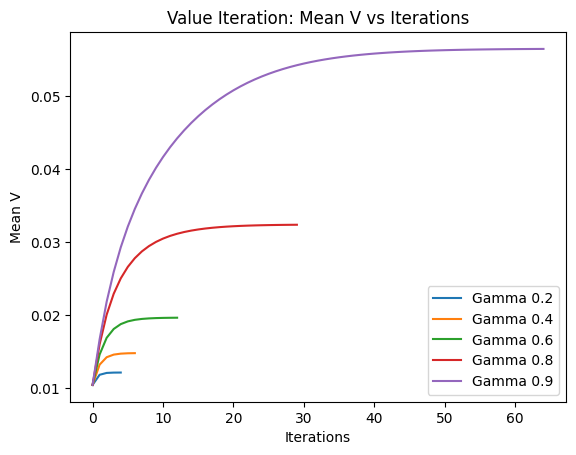

In [159]:
# Value Iteration Gamma plot
plt.figure()
plt.plot(val_iter_df[val_iter_df['gamma'] == 0.2]['Mean V'], label = "Gamma 0.2")
plt.plot(val_iter_df[val_iter_df['gamma'] == 0.4]['Mean V'], label = "Gamma 0.4")
plt.plot(val_iter_df[val_iter_df['gamma'] == 0.6]['Mean V'], label = "Gamma 0.6")
plt.plot(val_iter_df[val_iter_df['gamma'] == 0.8]['Mean V'], label = "Gamma 0.8")
plt.plot(val_iter_df[val_iter_df['gamma'] == 0.9]['Mean V'], label = "Gamma 0.9")
plt.xlabel('Iterations')
plt.ylabel('Mean V')
plt.title('Value Iteration: Mean V vs Iterations')
plt.legend()
plt.show()

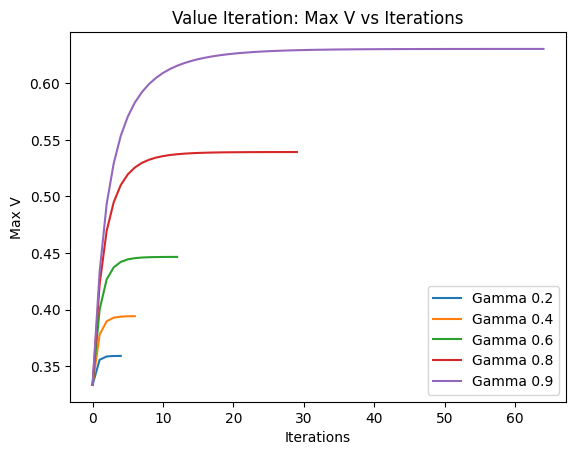

In [160]:
# Value Iteration Gamma plot
plt.figure()
plt.plot(val_iter_df[val_iter_df['gamma'] == 0.2]['Max V'], label = "Gamma 0.2")
plt.plot(val_iter_df[val_iter_df['gamma'] == 0.4]['Max V'], label = "Gamma 0.4")
plt.plot(val_iter_df[val_iter_df['gamma'] == 0.6]['Max V'], label = "Gamma 0.6")
plt.plot(val_iter_df[val_iter_df['gamma'] == 0.8]['Max V'], label = "Gamma 0.8")
plt.plot(val_iter_df[val_iter_df['gamma'] == 0.9]['Max V'], label = "Gamma 0.9")
plt.xlabel('Iterations')
plt.ylabel('Max V')
plt.title('Value Iteration: Max V vs Iterations')
plt.legend()
plt.show()

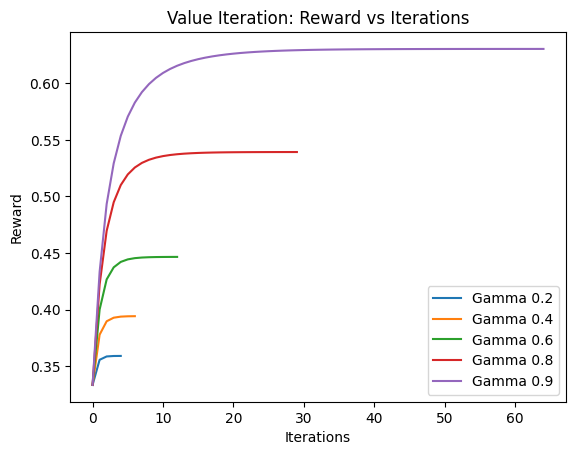

In [161]:
# Value Iteration Reward plot
plt.figure()
plt.plot(val_iter_df[val_iter_df['gamma'] == 0.2]['Reward'], label = "Gamma 0.2")
plt.plot(val_iter_df[val_iter_df['gamma'] == 0.4]['Reward'], label = "Gamma 0.4")
plt.plot(val_iter_df[val_iter_df['gamma'] == 0.6]['Reward'], label = "Gamma 0.6")
plt.plot(val_iter_df[val_iter_df['gamma'] == 0.8]['Reward'], label = "Gamma 0.8")
plt.plot(val_iter_df[val_iter_df['gamma'] == 0.9]['Reward'], label = "Gamma 0.9")
plt.xlabel('Iterations')
plt.ylabel('Reward')
plt.title('Value Iteration: Reward vs Iterations')
plt.legend()
plt.show()

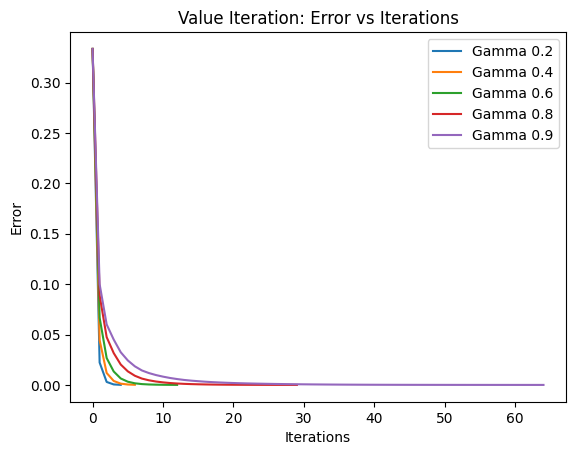

In [162]:
# Value Iteration Error plot
plt.figure()
plt.plot(val_iter_df[val_iter_df['gamma'] == 0.2]['Error'], label = "Gamma 0.2")
plt.plot(val_iter_df[val_iter_df['gamma'] == 0.4]['Error'], label = "Gamma 0.4")
plt.plot(val_iter_df[val_iter_df['gamma'] == 0.6]['Error'], label = "Gamma 0.6")
plt.plot(val_iter_df[val_iter_df['gamma'] == 0.8]['Error'], label = "Gamma 0.8")
plt.plot(val_iter_df[val_iter_df['gamma'] == 0.9]['Error'], label = "Gamma 0.9")
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.title('Value Iteration: Error vs Iterations')
plt.legend()
plt.show()

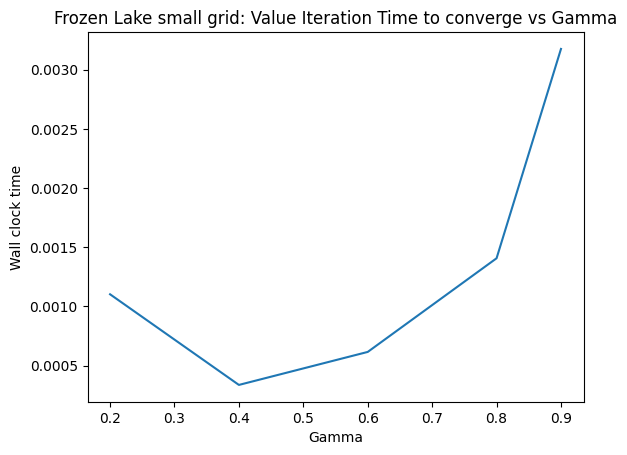

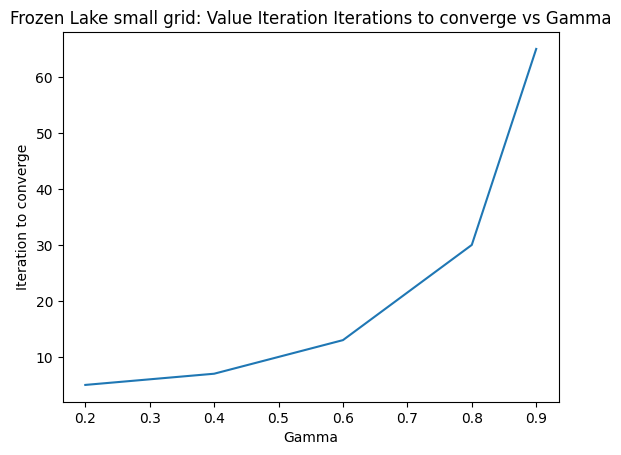

In [163]:
vlg = pd.DataFrame(val_iter_df[['gamma','Time','Iteration','Max V']].
                   groupby('gamma').apply(lambda x: x.iloc[[ -1]]))
# print(vlg)

plt.plot(vlg['gamma'], vlg['Time'])
plt.xlabel('Gamma')
plt.ylabel('Wall clock time')
plt.title('Frozen Lake small grid: Value Iteration Time to converge vs Gamma')
plt.show()

plt.plot(vlg['gamma'], vlg['Iteration'])
plt.xlabel('Gamma')
plt.ylabel('Iteration to converge')
plt.title('Frozen Lake small grid: Value Iteration Iterations to converge vs Gamma')
plt.show()

In [99]:
#sns.heatmap(np.reshape(vi.policy, (8,8)))

def int_str(pol):
    new_pol = np.empty(64, dtype='object')
    new_pol = np.reshape(new_pol,(8,8))
    for i in range(pol.shape[0]):
        for j in range(pol.shape[1]):
            #print(i,j)
            if pol[i][j] == 0:
                new_pol[i][j] = 'L'
            elif pol[i][j] == 1:
                new_pol[i][j] = 'D'
            elif pol[i][j] == 2:
                new_pol[i][j] = 'R'
            else:
                new_pol[i][j] = 'U'
    return new_pol

pol = np.reshape(vi.policy, (8,8))
adj_pol = int_str(pol)
print(pol)
print(adj_pol)


[[0 0 1 2 2 2 2 2]
 [0 1 1 3 2 2 1 1]
 [1 1 0 0 2 3 2 1]
 [1 2 2 1 0 0 2 1]
 [2 2 0 0 2 1 3 2]
 [0 0 0 1 3 0 0 2]
 [0 0 1 0 0 0 0 2]
 [1 1 0 0 1 1 1 0]]
[['L' 'L' 'D' 'R' 'R' 'R' 'R' 'R']
 ['L' 'D' 'D' 'U' 'R' 'R' 'D' 'D']
 ['D' 'D' 'L' 'L' 'R' 'U' 'R' 'D']
 ['D' 'R' 'R' 'D' 'L' 'L' 'R' 'D']
 ['R' 'R' 'L' 'L' 'R' 'D' 'U' 'R']
 ['L' 'L' 'L' 'D' 'U' 'L' 'L' 'R']
 ['L' 'L' 'D' 'L' 'L' 'L' 'L' 'R']
 ['D' 'D' 'L' 'L' 'D' 'D' 'D' 'L']]


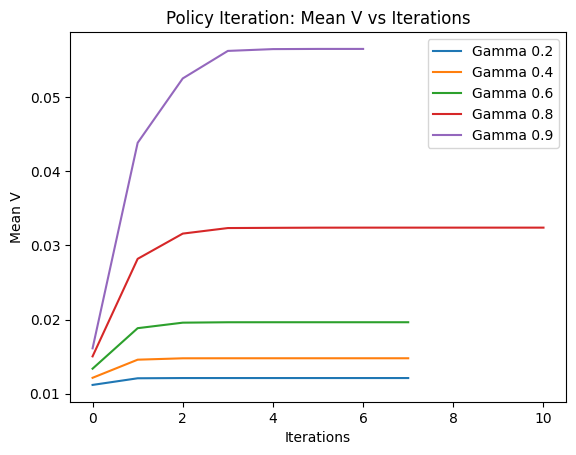

In [164]:
# Policy Iteration Gamma plot
plt.figure()
plt.plot(pol_iter_df[pol_iter_df['gamma'] == 0.2]['Mean V'], label = "Gamma 0.2")
plt.plot(pol_iter_df[pol_iter_df['gamma'] == 0.4]['Mean V'], label = "Gamma 0.4")
plt.plot(pol_iter_df[pol_iter_df['gamma'] == 0.6]['Mean V'], label = "Gamma 0.6")
plt.plot(pol_iter_df[pol_iter_df['gamma'] == 0.8]['Mean V'], label = "Gamma 0.8")
plt.plot(pol_iter_df[pol_iter_df['gamma'] == 0.9]['Mean V'], label = "Gamma 0.9")
plt.xlabel('Iterations')
plt.ylabel('Mean V')
plt.title('Policy Iteration: Mean V vs Iterations')
plt.legend()
plt.show()

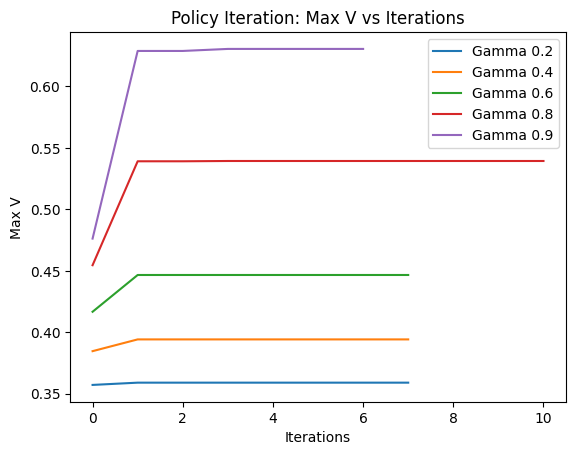

In [154]:
# Policy Iteration Gamma plot
plt.figure()
plt.plot(pol_iter_df[pol_iter_df['gamma'] == 0.2]['Max V'], label = "Gamma 0.2")
plt.plot(pol_iter_df[pol_iter_df['gamma'] == 0.4]['Max V'], label = "Gamma 0.4")
plt.plot(pol_iter_df[pol_iter_df['gamma'] == 0.6]['Max V'], label = "Gamma 0.6")
plt.plot(pol_iter_df[pol_iter_df['gamma'] == 0.8]['Max V'], label = "Gamma 0.8")
plt.plot(pol_iter_df[pol_iter_df['gamma'] == 0.9]['Max V'], label = "Gamma 0.9")
plt.xlabel('Iterations')
plt.ylabel('Max V')
plt.title('Policy Iteration: Max V vs Iterations')
plt.legend()
plt.show()

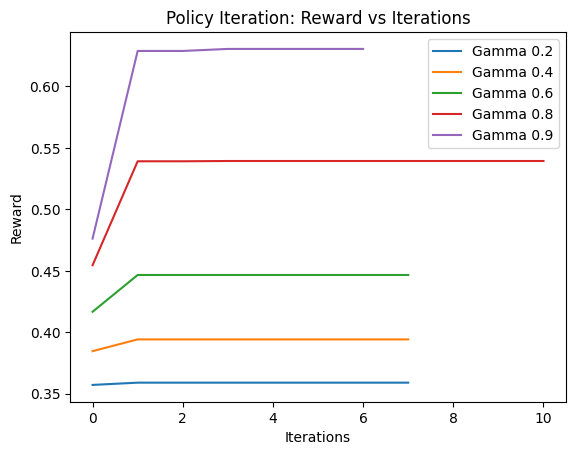

In [155]:
# Policy Iteration Reward plot
plt.figure()
plt.plot(pol_iter_df[pol_iter_df['gamma'] == 0.2]['Reward'], label = "Gamma 0.2")
plt.plot(pol_iter_df[pol_iter_df['gamma'] == 0.4]['Reward'], label = "Gamma 0.4")
plt.plot(pol_iter_df[pol_iter_df['gamma'] == 0.6]['Reward'], label = "Gamma 0.6")
plt.plot(pol_iter_df[pol_iter_df['gamma'] == 0.8]['Reward'], label = "Gamma 0.8")
plt.plot(pol_iter_df[pol_iter_df['gamma'] == 0.9]['Reward'], label = "Gamma 0.9")
plt.xlabel('Iterations')
plt.ylabel('Reward')
plt.title('Policy Iteration: Reward vs Iterations')
plt.legend()
plt.show()

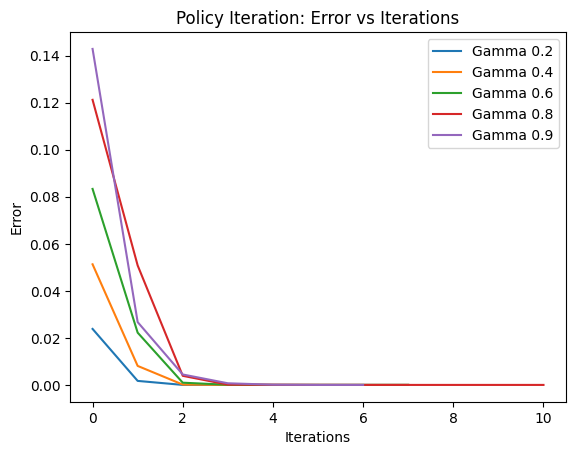

In [156]:
# Policy Iteration Error plot
plt.figure()
plt.plot(pol_iter_df[pol_iter_df['gamma'] == 0.2]['Error'], label = "Gamma 0.2")
plt.plot(pol_iter_df[pol_iter_df['gamma'] == 0.4]['Error'], label = "Gamma 0.4")
plt.plot(pol_iter_df[pol_iter_df['gamma'] == 0.6]['Error'], label = "Gamma 0.6")
plt.plot(pol_iter_df[pol_iter_df['gamma'] == 0.8]['Error'], label = "Gamma 0.8")
plt.plot(pol_iter_df[pol_iter_df['gamma'] == 0.9]['Error'], label = "Gamma 0.9")
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.title('Policy Iteration: Error vs Iterations')
plt.legend()
plt.show()

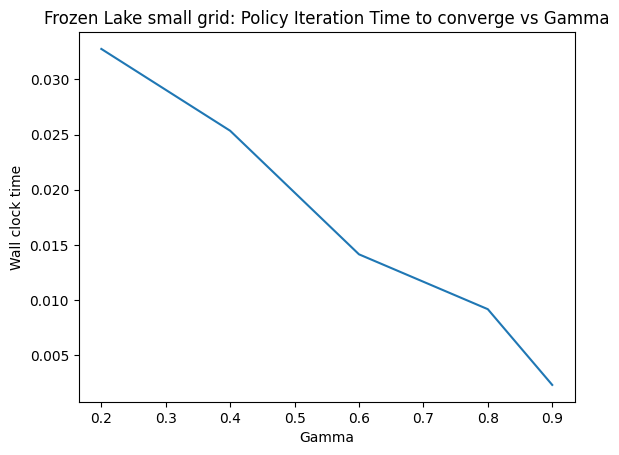

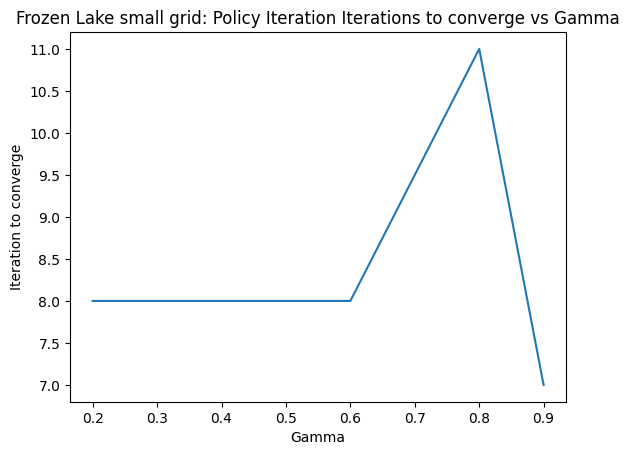

In [157]:
plg = pd.DataFrame(pol_iter_df[['gamma','Time','Iteration','Max V']].
                   groupby('gamma').apply(lambda x: x.iloc[[ -1]]))
# print(vlg)

plt.plot(plg['gamma'], plg['Time'])
plt.xlabel('Gamma')
plt.ylabel('Wall clock time')
plt.title('Frozen Lake small grid: Policy Iteration Time to converge vs Gamma')
plt.show()

plt.plot(plg['gamma'], plg['Iteration'])
plt.xlabel('Gamma')
plt.ylabel('Iteration to converge')
plt.title('Frozen Lake small grid: Policy Iteration Iterations to converge vs Gamma')
plt.show()

In [105]:
pol_iter_df

,State,Action,Reward,Error,Time,Max V,Mean V,Iteration,gamma
0,None,None,0.357143,2.380952e-02,0.007614,0.357143,0.011188,1,0.2
1,None,None,0.358984,1.709402e-03,0.009300,0.358984,0.012084,2,0.2
2,None,None,0.358984,7.660974e-06,0.011711,0.358984,0.012115,3,0.2
3,None,None,0.358984,3.520623e-08,0.012955,0.358984,0.012115,4,0.2
4,None,None,0.358984,3.273502e-11,0.014161,0.358984,0.012115,5,0.2
5,None,None,0.358984,2.202353e-12,0.016971,0.358984,0.012115,6,0.2
6,None,None,0.358984,1.591516e-13,0.017791,0.358984,0.012115,7,0.2
7,None,None,0.358984,5.551115e-17,0.018953,0.358984,0.012115,8,0.2
0,None,None,0.384615,5.128205e-02,0.002202,0.384615,0.012147,1,0.4
1,None,None,0.394177,8.080808e-03,0.002548,0.394177,0.014591,2,0.4


# Q Learning

In [ ]:
# Reference: https://www.baeldung.com/cs/epsilon-greedy-q-learning


In [1]:
def run_ql(gamma_val=[0.8], alpha_val=[1], epsilon_val=[1], ad=[0.9], ed=[0.95], iteration=[1e5]):
   
    
    ind_size = len(gamma_val)*len(alpha_val)*len(epsilon_val)*len(ad)*len(ed)*len(iteration)
    ql_df = pd.DataFrame(0,index=np.arange(ind_size), 
                         columns=['gamma','alpha','epsilon','alpha_decay','epsilon_decay','time',
                                  'iterations','reward','mean_rewards','max_rewards','error','policy'])
    qlearn_df = pd.DataFrame()
    counter_val = 0
    for j in alpha_val:
        for k in epsilon_val:
            for l in ad:
                for m in ed:
                    for n in iteration:
#                         ql = QLearning(mdp_p, mdp_r, n_iter=n, gamma=0.8, alpha=j, epsilon=k,
#                                        alpha_decay=l, epsilon_decay=m, alpha_min=0.001)
                        ql = QLearning(mdp_p, mdp_r, n_iter=n, gamma=0.8, alpha=j, epsilon=k
                                       )
                        qlo = ql.run()
                        temp_df = pd.DataFrame(qlo)
                        print(len(qlo))
                        temp_df['gamma'] = 0.8
                        temp_df['alpha'] = j
                        temp_df['epsilon'] = k
                        temp_df['alpha_decay'] = l
                        temp_df['epsilon_decay'] = m
                        temp_df['n_iter'] = n
                        time  = qlo[-1]['Time']
                        iters = qlo[-1]['Iteration']
                        max_val  = qlo[-1]['Max V']
                        max_rewards, mean_rewards, errors = [], [], []
                        for o in qlo:
                            max_rewards.append(o['Max V'])
                            mean_rewards.append(o['Mean V'])
                            errors.append(o['Error']) 
                        policy = np.array(ql.policy)
                        policy = np.reshape(policy, (8,8))
                        
                        ql_df['gamma'][counter_val] = 0.8
                        ql_df['alpha'][counter_val] = j
                        ql_df['epsilon'][counter_val] = k
                        ql_df['alpha_decay'][counter_val] = l
                        ql_df['epsilon_decay'][counter_val] = m
                        ql_df['time'][counter_val] = time
                        ql_df['iterations'][counter_val] = iters
                        ql_df['reward'][counter_val] = max_val
                        ql_df['mean_rewards'][counter_val] = {tuple(mean_rewards)}
                        ql_df['max_rewards'][counter_val] = {tuple(max_rewards)}
                        ql_df['error'][counter_val] = {tuple(errors)}
                        ql_df['policy'][counter_val] = {ql.policy}
                        
                        counter_val += 1
                        
                        
                        qlearn_df = qlearn_df.append(temp_df)
                        
                        
    return ql_df,qlearn_df
                        
                        


In [177]:
init_time = time.time()
ql_df,qlearn_df = run_ql(gamma_val=[0.8], alpha_val=[1,0.9,0.8], epsilon_val=[1,0.9,0.8], ad=[0.9], ed=[0.95], iteration=[1e5,1e7])
print("Time taken to run:", time.time() - init_time)

KeyboardInterrupt: 

In [2]:
init_time = time.time()
ql_df,qlearn_df = run_ql(gamma_val=[0.8], alpha_val=[0.8], epsilon_val=[0.1,0.2,0.4,0.6,0.8,0.9], ad=[0.9], ed=[0.95], iteration=[1e5])
print("Time taken to run:", time.time() - init_time)

NameError: name 'time' is not defined

In [188]:
ql_df

,gamma,alpha,epsilon,alpha_decay,epsilon_decay,time,iterations,reward,mean_rewards,max_rewards,error,policy
0,0.8,0.8,0.1,0.9,0.95,3.410095,100000,0.011471,"{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0,..."
1,0.8,0.8,0.2,0.9,0.95,3.343263,100000,0.012757,"{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(0, 2, 3, 3, 2, 2, 1, 0, 1, 1, 1, 2, 3, 0, 2,..."
2,0.8,0.8,0.4,0.9,0.95,3.450416,100000,0.012114,"{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 2, 3, 0, 0,..."
3,0.8,0.8,0.6,0.9,0.95,3.371052,100000,0.011471,"{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(3, 3, 3, 1, 0, 0, 0, 0, 3, 3, 3, 2, 2, 1, 0,..."
4,0.8,0.8,0.8,0.9,0.95,3.381360,100000,0.009857,"{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(0, 2, 0, 2, 1, 2, 3, 0, 2, 1, 1, 1, 3, 3, 1,..."
5,0.8,0.8,0.9,0.9,0.95,3.381983,100000,0.016677,"{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(2, 3, 2, 2, 0, 3, 2, 0, 3, 3, 2, 2, 1, 1, 2,..."


In [189]:
qlearn_df

,State,Action,Reward,Error,Time,Alpha,Epsilon,Gamma,Max V,Mean V,Iteration,gamma,alpha,epsilon,alpha_decay,epsilon_decay,n_iter
0,2,0,0.0,0.0,0.000242,0.001,0.1,0.8,0.011471,0.000248,10,0.8,0.8,0.1,0.9,0.95,100000.0
1,16,0,0.0,0.0,0.000525,0.001,0.1,0.8,0.011471,0.000248,20,0.8,0.8,0.1,0.9,0.95,100000.0
2,16,0,0.0,0.0,0.000787,0.001,0.1,0.8,0.011471,0.000248,30,0.8,0.8,0.1,0.9,0.95,100000.0
3,16,0,0.0,0.0,0.001052,0.001,0.1,0.8,0.011471,0.000248,40,0.8,0.8,0.1,0.9,0.95,100000.0
4,49,0,0.0,0.0,0.001410,0.001,0.1,0.8,0.011471,0.000248,50,0.8,0.8,0.1,0.9,0.95,100000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,35,0,0.0,0.0,3.379601,0.001,0.1,0.8,0.040859,0.001015,99960,0.8,0.8,0.9,0.9,0.95,100000.0
9996,35,0,0.0,0.0,3.379936,0.001,0.1,0.8,0.040859,0.001015,99970,0.8,0.8,0.9,0.9,0.95,100000.0
9997,35,0,0.0,0.0,3.380279,0.001,0.1,0.8,0.040859,0.001015,99980,0.8,0.8,0.9,0.9,0.95,100000.0
9998,35,0,0.0,0.0,3.380621,0.001,0.1,0.8,0.040859,0.001015,99990,0.8,0.8,0.9,0.9,0.95,100000.0


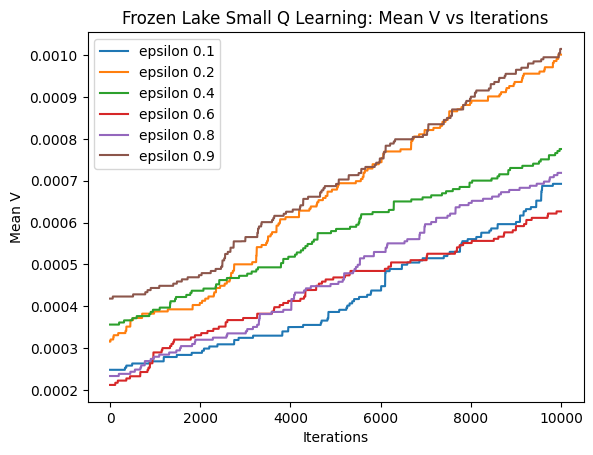

In [190]:
plt.figure()
plt.plot(qlearn_df[qlearn_df['epsilon'] == 0.1]['Mean V'], label = "epsilon 0.1")
plt.plot(qlearn_df[qlearn_df['epsilon'] == 0.2]['Mean V'], label = "epsilon 0.2")
plt.plot(qlearn_df[qlearn_df['epsilon'] == 0.4]['Mean V'], label = "epsilon 0.4")
plt.plot(qlearn_df[qlearn_df['epsilon'] == 0.6]['Mean V'], label = "epsilon 0.6")
plt.plot(qlearn_df[qlearn_df['epsilon'] == 0.8]['Mean V'], label = "epsilon 0.8")
plt.plot(qlearn_df[qlearn_df['epsilon'] == 0.9]['Mean V'], label = "epsilon 0.9")
plt.xlabel('Iterations')
plt.ylabel('Mean V')
plt.title('Frozen Lake Small Q Learning: Mean V vs Iterations')
plt.legend()
plt.show()

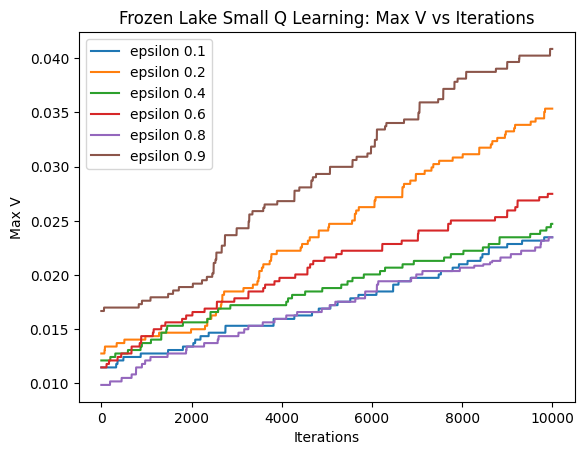

In [191]:
plt.figure()
plt.plot(qlearn_df[qlearn_df['epsilon'] == 0.1]['Max V'], label = "epsilon 0.1")
plt.plot(qlearn_df[qlearn_df['epsilon'] == 0.2]['Max V'], label = "epsilon 0.2")
plt.plot(qlearn_df[qlearn_df['epsilon'] == 0.4]['Max V'], label = "epsilon 0.4")
plt.plot(qlearn_df[qlearn_df['epsilon'] == 0.6]['Max V'], label = "epsilon 0.6")
plt.plot(qlearn_df[qlearn_df['epsilon'] == 0.8]['Max V'], label = "epsilon 0.8")
plt.plot(qlearn_df[qlearn_df['epsilon'] == 0.9]['Max V'], label = "epsilon 0.9")
plt.xlabel('Iterations')
plt.ylabel('Max V')
plt.title('Frozen Lake Small Q Learning: Max V vs Iterations')
plt.legend()
plt.show()

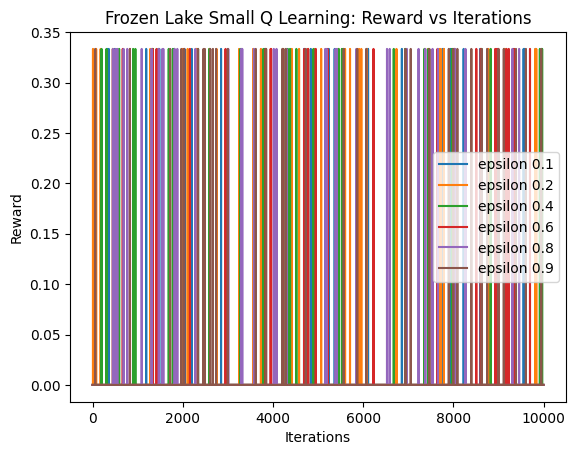

In [192]:
plt.figure()
plt.plot(qlearn_df[qlearn_df['epsilon'] == 0.1]['Reward'], label = "epsilon 0.1")
plt.plot(qlearn_df[qlearn_df['epsilon'] == 0.2]['Reward'], label = "epsilon 0.2")
plt.plot(qlearn_df[qlearn_df['epsilon'] == 0.4]['Reward'], label = "epsilon 0.4")
plt.plot(qlearn_df[qlearn_df['epsilon'] == 0.6]['Reward'], label = "epsilon 0.6")
plt.plot(qlearn_df[qlearn_df['epsilon'] == 0.8]['Reward'], label = "epsilon 0.8")
plt.plot(qlearn_df[qlearn_df['epsilon'] == 0.9]['Reward'], label = "epsilon 0.9")
plt.xlabel('Iterations')
plt.ylabel('Reward')
plt.title('Frozen Lake Small Q Learning: Reward vs Iterations')
plt.legend()
plt.show()

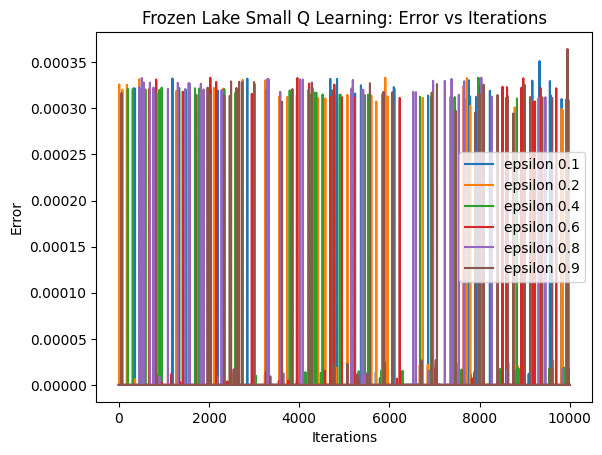

In [193]:
plt.figure()
plt.plot(qlearn_df[qlearn_df['epsilon'] == 0.1]['Error'], label = "epsilon 0.1")
plt.plot(qlearn_df[qlearn_df['epsilon'] == 0.2]['Error'], label = "epsilon 0.2")
plt.plot(qlearn_df[qlearn_df['epsilon'] == 0.4]['Error'], label = "epsilon 0.4")
plt.plot(qlearn_df[qlearn_df['epsilon'] == 0.6]['Error'], label = "epsilon 0.6")
plt.plot(qlearn_df[qlearn_df['epsilon'] == 0.8]['Error'], label = "epsilon 0.8")
plt.plot(qlearn_df[qlearn_df['epsilon'] == 0.9]['Error'], label = "epsilon 0.9")
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.title('Frozen Lake Small Q Learning: Error vs Iterations')
plt.legend()
plt.show()

In [109]:
time_init = time.time()
alpha_val = [0.2,0.4,0.6,0.8]
eps_val = [0.2,0.4,0.6,0.8]
ql_df = pd.DataFrame()
for i in alpha_val:
    for j in eps_val:
        ql = QLearning(mdp_p, mdp_r, n_iter=100000, gamma=0.8, alpha = i, epsilon=j)
        qlo = pd.DataFrame(ql.run())
        qlo['alpha_val'] = i
        qlo['eps_val'] = j
        ql_df = ql_df.append(qlo)
print("Time taken:", time.time() - time_init)

Time taken: 54.16946005821228


In [110]:
ql_df

,State,Action,Reward,Error,Time,Alpha,Epsilon,Gamma,Max V,Mean V,Iteration,alpha_val,eps_val
0,29,0,0.0,0.000000e+00,0.001614,0.182703,0.182703,0.8,0.000000,0.000000,10,0.2,0.2
1,29,0,0.0,0.000000e+00,0.002985,0.165234,0.165234,0.8,0.000000,0.000000,20,0.2,0.2
2,29,0,0.0,0.000000e+00,0.004564,0.149434,0.149434,0.8,0.000000,0.000000,30,0.2,0.2
3,29,0,0.0,0.000000e+00,0.006117,0.135146,0.135146,0.8,0.000000,0.000000,40,0.2,0.2
4,29,0,0.0,0.000000e+00,0.007452,0.122223,0.122223,0.8,0.000000,0.000000,50,0.2,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,19,0,0.0,0.000000e+00,3.377621,0.001000,0.100000,0.8,0.020365,0.000434,99960,0.8,0.8
9996,19,0,0.0,0.000000e+00,3.377913,0.001000,0.100000,0.8,0.020365,0.000434,99970,0.8,0.8
9997,19,0,0.0,0.000000e+00,3.378206,0.001000,0.100000,0.8,0.020365,0.000434,99980,0.8,0.8
9998,19,0,0.0,0.000000e+00,3.378499,0.001000,0.100000,0.8,0.020365,0.000434,99990,0.8,0.8


Time taken: 13.624928951263428


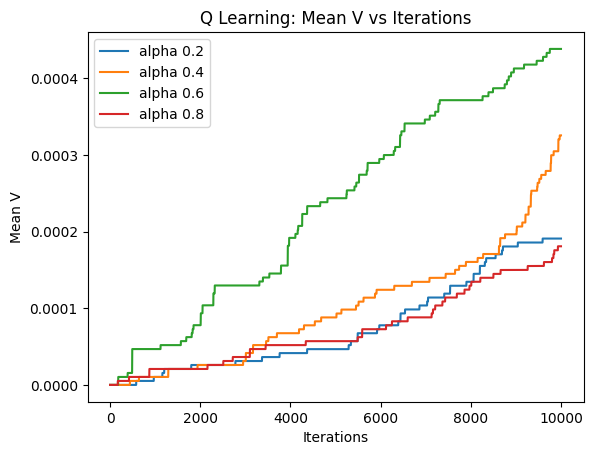

In [113]:
# Q Learning Alpha plot
time_init = time.time()
alpha_val = [0.2,0.4,0.6,0.8]
eps_val = [0.2,0.4,0.6,0.8]
gamma_val = [0.2,0.4,0.6,0.8]
ql_df = pd.DataFrame()
for i in alpha_val:
    ql = QLearning(mdp_p, mdp_r, n_iter=100000, gamma=0.8, alpha = i, epsilon=0.2)
    qlo = pd.DataFrame(ql.run())
    qlo['alpha_val'] = i
    ql_df = ql_df.append(qlo)
print("Time taken:", time.time() - time_init)
plt.figure()
plt.plot(ql_df[ql_df['alpha_val'] == 0.2]['Mean V'], label = "alpha 0.2")
plt.plot(ql_df[ql_df['alpha_val'] == 0.4]['Mean V'], label = "alpha 0.4")
plt.plot(ql_df[ql_df['alpha_val'] == 0.6]['Mean V'], label = "alpha 0.6")
plt.plot(ql_df[ql_df['alpha_val'] == 0.8]['Mean V'], label = "alpha 0.8")
plt.xlabel('Iterations')
plt.ylabel('Mean V')
plt.title('Q Learning: Mean V vs Iterations')
plt.legend()
plt.show()

Time taken: 13.574546098709106


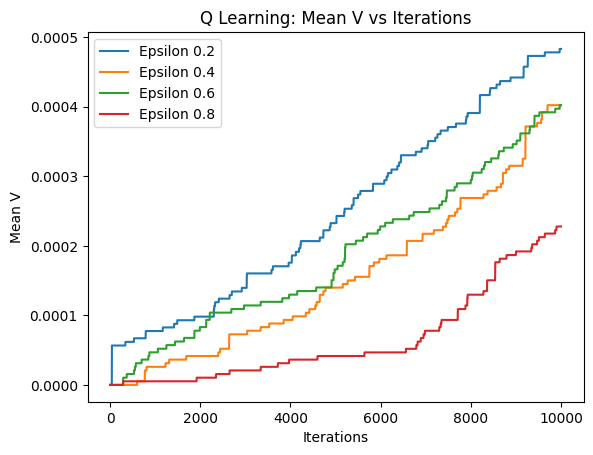

In [114]:
# Q Learning Epsilon plot
time_init = time.time()
alpha_val = [0.2,0.4,0.6,0.8]
eps_val = [0.2,0.4,0.6,0.8]
gamma_val = [0.2,0.4,0.6,0.8]
ql_df = pd.DataFrame()
for i in eps_val:
    ql = QLearning(mdp_p, mdp_r, n_iter=100000, gamma=0.8, alpha = 0.6, epsilon=i)
    qlo = pd.DataFrame(ql.run())
    qlo['eps_val'] = i
    ql_df = ql_df.append(qlo)
print("Time taken:", time.time() - time_init)
plt.figure()
plt.plot(ql_df[ql_df['eps_val'] == 0.2]['Mean V'], label = "Epsilon 0.2")
plt.plot(ql_df[ql_df['eps_val'] == 0.4]['Mean V'], label = "Epsilon 0.4")
plt.plot(ql_df[ql_df['eps_val'] == 0.6]['Mean V'], label = "Epsilon 0.6")
plt.plot(ql_df[ql_df['eps_val'] == 0.8]['Mean V'], label = "Epsilon 0.8")
plt.xlabel('Iterations')
plt.ylabel('Mean V')
plt.title('Q Learning: Mean V vs Iterations')
plt.legend()
plt.show()

Time taken: 13.532036066055298


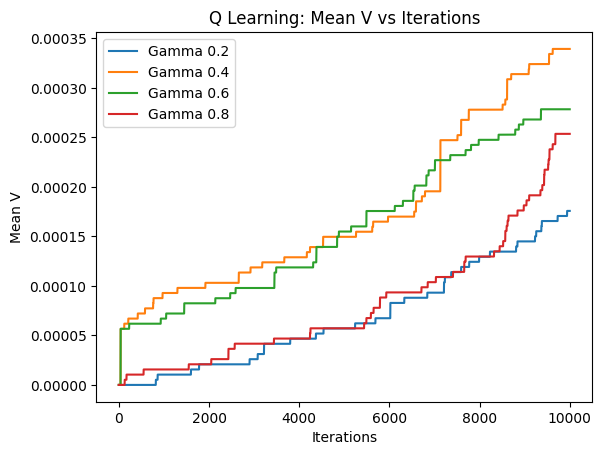

In [115]:
# Q Learning Gamma plot
time_init = time.time()
alpha_val = [0.2,0.4,0.6,0.8]
eps_val = [0.2,0.4,0.6,0.8]
gamma_val = [0.2,0.4,0.6,0.8]
ql_df = pd.DataFrame()
for i in gamma_val:
    ql = QLearning(mdp_p, mdp_r, n_iter=100000, gamma=i, alpha = 0.6, epsilon=0.2)
    qlo = pd.DataFrame(ql.run())
    qlo['gamma_val'] = i
    ql_df = ql_df.append(qlo)
print("Time taken:", time.time() - time_init)
plt.figure()
plt.plot(ql_df[ql_df['gamma_val'] == 0.2]['Mean V'], label = "Gamma 0.2")
plt.plot(ql_df[ql_df['gamma_val'] == 0.4]['Mean V'], label = "Gamma 0.4")
plt.plot(ql_df[ql_df['gamma_val'] == 0.6]['Mean V'], label = "Gamma 0.6")
plt.plot(ql_df[ql_df['gamma_val'] == 0.8]['Mean V'], label = "Gamma 0.8")
plt.xlabel('Iterations')
plt.ylabel('Mean V')
plt.title('Q Learning: Mean V vs Iterations')
plt.legend()
plt.show()

Time taken: 13.602999925613403


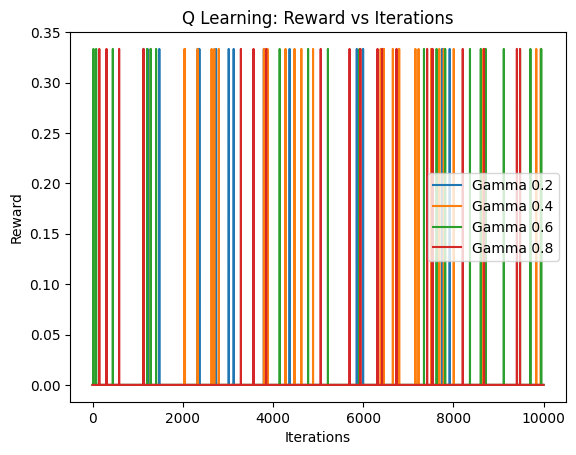

In [116]:
# Q Learning Gamma plot
time_init = time.time()
alpha_val = [0.2,0.4,0.6,0.8]
eps_val = [0.2,0.4,0.6,0.8]
gamma_val = [0.2,0.4,0.6,0.8]
ql_df = pd.DataFrame()
for i in gamma_val:
    ql = QLearning(mdp_p, mdp_r, n_iter=100000, gamma=i, alpha = 0.6, epsilon=0.2)
    qlo = pd.DataFrame(ql.run())
    qlo['gamma_val'] = i
    ql_df = ql_df.append(qlo)
print("Time taken:", time.time() - time_init)
plt.figure()
plt.plot(ql_df[ql_df['gamma_val'] == 0.2]['Reward'], label = "Gamma 0.2")
plt.plot(ql_df[ql_df['gamma_val'] == 0.4]['Reward'], label = "Gamma 0.4")
plt.plot(ql_df[ql_df['gamma_val'] == 0.6]['Reward'], label = "Gamma 0.6")
plt.plot(ql_df[ql_df['gamma_val'] == 0.8]['Reward'], label = "Gamma 0.8")
plt.xlabel('Iterations')
plt.ylabel('Reward')
plt.title('Q Learning: Reward vs Iterations')
plt.legend()
plt.show()

In [119]:
ql_df[ql_df['gamma_val'] == 0.4]['Reward'].describe()

count    10000.000000
mean         0.000933
std          0.017615
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.333333
Name: Reward, dtype: float64

Time taken: 13.528400182723999


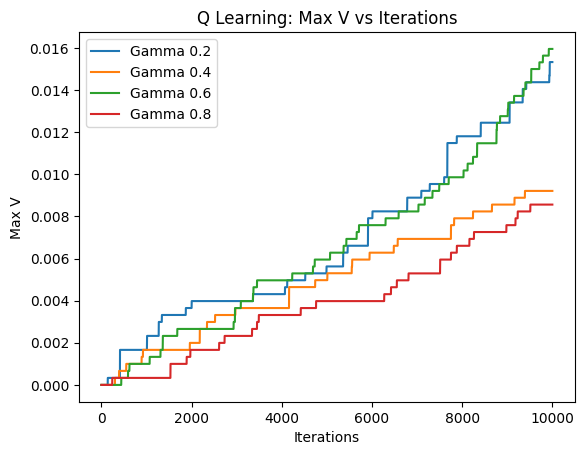

In [120]:
# Q Learning Gamma plot
time_init = time.time()
alpha_val = [0.2,0.4,0.6,0.8]
eps_val = [0.2,0.4,0.6,0.8]
gamma_val = [0.2,0.4,0.6,0.8]
ql_df = pd.DataFrame()
for i in gamma_val:
    ql = QLearning(mdp_p, mdp_r, n_iter=100000, gamma=i, alpha = 0.6, epsilon=0.2)
    qlo = pd.DataFrame(ql.run())
    qlo['gamma_val'] = i
    ql_df = ql_df.append(qlo)
print("Time taken:", time.time() - time_init)
plt.figure()
plt.plot(ql_df[ql_df['gamma_val'] == 0.2]['Max V'], label = "Gamma 0.2")
plt.plot(ql_df[ql_df['gamma_val'] == 0.4]['Max V'], label = "Gamma 0.4")
plt.plot(ql_df[ql_df['gamma_val'] == 0.6]['Max V'], label = "Gamma 0.6")
plt.plot(ql_df[ql_df['gamma_val'] == 0.8]['Max V'], label = "Gamma 0.8")
plt.xlabel('Iterations')
plt.ylabel('Max V')
plt.title('Q Learning: Max V vs Iterations')
plt.legend()
plt.show()

Time taken: 13.562745094299316


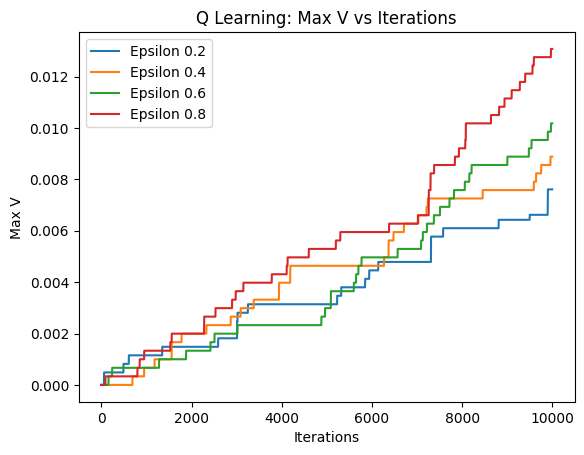

In [121]:
# Q Learning Epsilon plot
time_init = time.time()
alpha_val = [0.2,0.4,0.6,0.8]
eps_val = [0.2,0.4,0.6,0.8]
gamma_val = [0.2,0.4,0.6,0.8]
ql_df = pd.DataFrame()
for i in eps_val:
    ql = QLearning(mdp_p, mdp_r, n_iter=100000, gamma=0.8, alpha = 0.6, epsilon=i)
    qlo = pd.DataFrame(ql.run())
    qlo['eps_val'] = i
    ql_df = ql_df.append(qlo)
print("Time taken:", time.time() - time_init)
plt.figure()
plt.plot(ql_df[ql_df['eps_val'] == 0.2]['Max V'], label = "Epsilon 0.2")
plt.plot(ql_df[ql_df['eps_val'] == 0.4]['Max V'], label = "Epsilon 0.4")
plt.plot(ql_df[ql_df['eps_val'] == 0.6]['Max V'], label = "Epsilon 0.6")
plt.plot(ql_df[ql_df['eps_val'] == 0.8]['Max V'], label = "Epsilon 0.8")
plt.xlabel('Iterations')
plt.ylabel('Max V')
plt.title('Q Learning: Max V vs Iterations')
plt.legend()
plt.show()

Time taken: 14.366206884384155


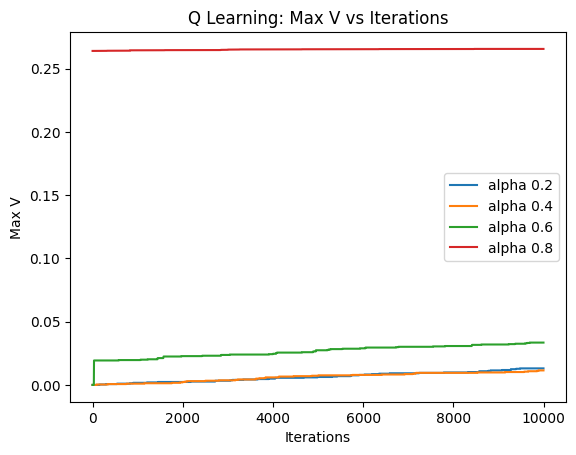

In [122]:
# Q Learning Alpha plot
time_init = time.time()
alpha_val = [0.2,0.4,0.6,0.8]
eps_val = [0.2,0.4,0.6,0.8]
gamma_val = [0.2,0.4,0.6,0.8]
ql_df = pd.DataFrame()
for i in alpha_val:
    ql = QLearning(mdp_p, mdp_r, n_iter=100000, gamma=0.8, alpha = i, epsilon=0.2)
    qlo = pd.DataFrame(ql.run())
    qlo['alpha_val'] = i
    ql_df = ql_df.append(qlo)
print("Time taken:", time.time() - time_init)
plt.figure()
plt.plot(ql_df[ql_df['alpha_val'] == 0.2]['Max V'], label = "alpha 0.2")
plt.plot(ql_df[ql_df['alpha_val'] == 0.4]['Max V'], label = "alpha 0.4")
plt.plot(ql_df[ql_df['alpha_val'] == 0.6]['Max V'], label = "alpha 0.6")
plt.plot(ql_df[ql_df['alpha_val'] == 0.8]['Max V'], label = "alpha 0.8")
plt.xlabel('Iterations')
plt.ylabel('Max V')
plt.title('Q Learning: Max V vs Iterations')
plt.legend()
plt.show()